In [47]:
from functions import *
import re
import networkx as nx
from dask.distributed import Client
from nltk.util import ngrams
from dask import delayed
from dask import bag as db
from dask import compute
from nltk.util import ngrams
from sklearn.feature_extraction.text import HashingVectorizer , TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import dask_ml.feature_extraction.text as dask_text
import dask
from itertools import chain
from dask import bag as db
from dask import dataframe as dd
from itertools import chain
import pandas as pd
import dask.array as da
import itertools
from dask.distributed import get_client
from umap import UMAP
import hdbscan
import time
from scipy.sparse import csr_matrix
import seaborn as sns

import matplotlib.pyplot as plt
from glob import glob
from nltk.util import ngrams
import sys
import cython
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [2]:
import numpy as np

In [3]:
n = 13
sys.getsizeof(np.zeros(4**n- 4**(n//2)))/1e9

0.53683824

In [ ]:
%%time
from itertools import product 

table = {}
for num,i in enumerate(product(b'ACGT', repeat=4)):
    table[bytes(i)] = num


In [ ]:
list(range(20-2,-1,-1))

In [4]:
import pyximport;pyximport.install(language_level = '3')
import ngrams_fast as ngf
import ngrams_fast_v2 as ngf2
import cyrevhashvec as crhv


In [ ]:
cwindow = np.array([1,2,3,4,5,6,7,8,9,0])
for i in range(len(cwindow)-1): cwindow[i] = cwindow[i+1]
print(cwindow)

invcwindow = np.array([1,2,3,4,5,6,7,8,9,0])
for i in range(len(invcwindow)-2,-1,-1): invcwindow[i+1] = invcwindow[i]
print(invcwindow)
    
    

In [ ]:
%time B = ngf.listkmers('data/000genome.txt',20)
%time A = list(ngf.yieldkmers('data/000genome.txt',20))
%time C = list(ngf2.cyngrams('data/000genome.txt',20))
%time D = ngf2.listcyngrams_fastpy('data/000genome.txt',20)

In [ ]:
for name in sorted(glob('data/*genome.txt')):
    if ngf2.listcyngrams_fastpy('data/000genome.txt',20) != list(ngf.yieldkmers('data/000genome.txt',20)): print('false!!!')
    else: print('OK')

In [ ]:
%%cython -a
# cython: boundscheck = False
from libc.stdlib cimport malloc, free
from libc.stdio cimport fopen, fclose, FILE, EOF, fgetc, feof
cimport numpy as cnp



cdef unsigned char char_transform(char chars):
    if chars == 65: return 84
    elif chars == 67: return 71
    elif chars == 71: return 67
    elif chars == 84: return 65
    return 78

cdef char check_sort(unsigned char * fw, unsigned char * rv, int klen):
    cdef int i
    for i in range(klen):
        if fw[i] < rv[i]: return 1
        elif fw[i] > rv[ i]: return 0
    return 1


def cyngrams(str filename, int klen):
    """Efficiently read in a file"""
    cdef FILE *fp = NULL # create a file pointer
    fp = fopen(filename.encode(encoding='utf-8'), "rb")
    if fp == NULL:
        raise FileNotFoundError(2, "No such file or directory: '%s'" % filename)
        
    # file parsing variables
    cdef char c 
    cdef int i
    cdef int is_line = 1 
    cdef int window_pos = 0
    cdef bytes pywindow 
    cdef unsigned char *cwindow = <unsigned char *> malloc((klen+1)*sizeof(char))
    cdef unsigned char *invcwindow = <unsigned char *> malloc((klen+1)*sizeof(char))
    
    #cdef int stopearly = 0
    # bypass the gil
    #with nogil:
    while 1 :
        c = fgetc(fp)
        if feof(fp): break
        if c == 78: window_pos = 0
        elif c == 10: 
            is_line += 1
            if is_line > 4: is_line= 1
            window_pos = 0
        elif is_line == 2: 
            cwindow[window_pos] = c
            invcwindow[klen - window_pos-1] = char_transform(c)
            window_pos += 1
            if window_pos == klen: 
                if check_sort(cwindow, invcwindow, klen ) == 1: yield cwindow
                else: yield invcwindow
                #yield cwindow
                #yield invcwindow
                for i in range(klen-1): cwindow[i] = cwindow[i+1]
                for i in range(klen-2,-1,-1): invcwindow[i+1] = invcwindow[i]
                window_pos -= 1
    # close the file
    free(cwindow)
    free(invcwindow)
    fclose(fp)
    return

#def cypyngrams()

In [ ]:
%time A = list(ngf.yieldkmers('data/000genome.txt',20))

In [ ]:
A == a

In [ ]:
%time a = list(cyngrams('data/000genome.txt',20))

In [ ]:
a[:10]

In [ ]:
for i in range(100):
    print (a[i], A[i])

In [ ]:
%%cython -a

tab_b = bytes.maketrans(b"ACGT", b"TGCA")

def bRevComp(seq):
    return seq.translate(tab_b)[::-1]

cdef int char_transform(int char):
    if char == 65: return 84
    elif char == 67: return 71
    elif char == 71: return 67
    elif char == 84: return 65
    return 78

cdef OK(unsigned char *kmer, int val):
    cdef int i = 0
    while i < val:
        if kmer[i] <char_transform(kmer[val - i-1]):
            return kmer
        elif kmer[i] > char_transform(kmer[val - i-1]):
            return bRevComp(kmer)
        i +=1
    return kmer

def sklearn_ngram_fast(text, n):
    cdef int text_len = len(text)
    cdef list ngrams = []
    ngrams_append = ngrams.append
    for i in range(text_len - n + 1):
        ngrams_append(OK(text[i: i + n], n))
    return ngrams

def sklearn_ngram_yield_fast(text, n):
    cdef int text_len = len(text)
    for i in range(text_len - n + 1):
        yield OK(text[i: i + n], n)
        

In [ ]:
def ngram_yield( filename, klen = 20):
    with open(filename, 'rb') as f:
        while 1:
            if not f.readline(): break
            for i in sklearn_ngram_yield_fast(f.readline(), klen): yield i
            f.readline()
            f.readline()   
            
def ngram_list( filename, klen = 20):
    ngrams = []
    ngrams_append = ngrams.append
    with open(filename, 'rb') as f:
        while 1:
            if not f.readline(): break
            for i in sklearn_ngram_yield_fast(f.readline(), klen): ngrams.append(i)
            f.readline()
            f.readline() 
    return ngrams
    

In [ ]:
a = 1234
a %= 1000
a

In [ ]:
1234%1000

## No string version


In [48]:
%%cython -a
import numpy as np   
import scipy.sparse as sp

from libc.stdlib cimport malloc, free
from libc.stdio cimport fopen, fclose, FILE, EOF, fgetc, feof
from cython.parallel import prange
cimport numpy as cnp
cimport cython

cdef int char2int(char chars) nogil:
    if chars == 65: return 0
    elif chars == 67: return 1
    elif chars == 71: return 2
    elif chars == 84: return 3
    return -1

cdef int invchar2int(char chars) nogil:
    if chars == 65: return 3
    elif chars == 67: return 2
    elif chars == 71: return 1
    elif chars == 84: return 0
    return -1


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)
cdef cykmerarray(str filename, int klen, unsigned long max_size = -1): ##unsigned long is up to 32bp cnp.uint16_t[:]
    """Efficiently read in a file"""
    cdef FILE *fp = NULL # create a file pointer
    fp = fopen(filename.encode(encoding='utf-8'), "rb")
    if fp == NULL:
        raise FileNotFoundError(2, "No such file or directory: '%s'" % filename)
    # file parsing variables
    cdef unsigned long array_size = 4**klen - 4**(klen//2)
    cdef unsigned long fw_div = 4**(klen-1)
    
    if max_size > 0 and max_size < array_size:
        array_size = max_size
    
    cdef char c 
    cdef int i
    cdef int is_line = 1 
    cdef int window_pos = 0
    cdef bytes pywindow 
    cdef unsigned long fw_num = 0
    cdef unsigned long rv_num = 0
    #cdef list col = []
    cdef cnp.ndarray[cnp.int16_t, ndim=1] result = np.zeros((array_size), dtype = np.int16)
    
    #cdef int stopearly = 0
    # bypass the gil
    with nogil:
        while 1 :
            c = fgetc(fp)
            if feof(fp): break
            if c == 78: window_pos = 0
            elif c == 10: 
                is_line += 1
                if is_line > 4: is_line= 1
                window_pos = 0
            elif is_line == 2: 
                fw_num = fw_num*4 + char2int(c)
                rv_num = invchar2int(c)*(4**window_pos) + rv_num
                window_pos += 1
                if window_pos == klen: 
                    if fw_num < rv_num: result[fw_num%max_size] += 1
                    else: result[rv_num%max_size] += 1
                    fw_num %= fw_div
                    rv_num //= 4
                    window_pos -= 1
    # close the file
    fclose(fp)
    return result

def cyhashvecSMALLK(filenames = [], int klen = 13, max_size = -1):
    if max_size > 1e9: 
        print('this will use more than 1 gb per file')
        return -1
    cdef long size = 4**klen - 4**(klen//2)  #cdef long long 
    if max_size > 0 and max_size < size:
        size = max_size
    cdef int corpus_size = len(filenames)
    for  num,name  in enumerate(filenames):
        if num == 0: ret = sp.csr_matrix(cykmerarray(name, klen, size))
        else: ret = sp.vstack((ret, cykmerarray(name, klen, size)))
    return ret




In [49]:
%time B = cyhashvecSMALLK(['data/001genome.txt','data/002genome.txt'], klen = 20, max_size = 1e7)


CPU times: user 1.29 s, sys: 15.3 ms, total: 1.3 s
Wall time: 1.3 s


In [46]:
B + C

<1x10000000 sparse matrix of type '<class 'numpy.int16'>'
	with 1720506 stored elements in Compressed Sparse Row format>

In [ ]:
def sklearn_ngram_yield_fast(text, n):
    text_len = len(text)
    for i in range(text_len - n + 1):
        yield OK(text[i: i + n], n)

In [ ]:
%time A = list(kmers('data/000genome.txt',20))

In [ ]:
%timeit sklearn_ngram_fast(b'ATGTACGCAT', 2)

In [ ]:
sys.getsizeof(np.zeros(int(1e9),dtype = np.uint16))/1e9

In [28]:
B

<1x10000000 sparse matrix of type '<class 'numpy.uint16'>'
	with 924750 stored elements in Compressed Sparse Row format>

In [ ]:
@njit 
def numbard(dataset, k):
    window = np.zeros(k)
    ret = []
    is_line = 1
    cnt = 0
    for char in dataset:
        if char == 10: 
            is_line += 1
            if is_line > 4: is_line= 1
            cnt = 0
        elif is_line == 2: 
            if char == 78: cnt = 0
            else:
                window[cnt] = char
                cnt += 1
                if cnt == k: 
                    ret.append(window)
                    cnt -= 1
                    window[:19] = window [1:20]
    return ret

In [ ]:
#cython: infer_types=True


## memory safe cython


In [ ]:
%%cython -a
import numpy as np   
import scipy.sparse as sp

from libc.stdlib cimport malloc, free
from libc.stdio cimport fopen, fclose, FILE, EOF, fgetc, feof
from cython.parallel import prange
cimport numpy as cnp
cimport cython

cdef unsigned char char_rev(unsigned char chars):
    if chars == 65: return 84
    elif chars == 67: return 71
    elif chars == 71: return 67
    elif chars == 84: return 65
    return 78

cdef unsigned char char2int(char chars):
    if chars == 65: return 0
    elif chars == 67: return 1
    elif chars == 71: return 2
    elif chars == 84: return 3
    return -1

cdef char check_sort2(unsigned char * fw, unsigned char * rv, int klen):  #nogil
    cdef int i
    for i in range(klen):
        if fw[i] < rv[i]: return 1
        elif fw[i] > rv[ i]: return 0
    return 1

cdef int RevHash(unsigned char *kmer, int klen):
    cdef unsigned char c
    cdef int rev = 0
    cdef int i
    for i in range(klen):
        rev = rev*4 + char2int(kmer[i])
    return rev

cdef unsigned long longRevHash(unsigned char *kmer, unsigned long max_size, int klen):
    cdef unsigned char c
    cdef unsigned long int rev = 0
    cdef int i
    for i in range(klen):
        rev = rev*4 + char2int(kmer[i])
    return rev%max_size
    #return rev

def longRevHashPY(kmer, max_s, klen):
    return longRevHash(kmer, max_s, klen)

#cdef np.ndarray[np.int_t, ndim=1] cykmerarray(str filename, int klen):
@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)
cdef cykmerarray(str filename, int klen, unsigned long max_size = -1): ##unsigned long is up to 32bp
    """Efficiently read in a file"""
    cdef FILE *fp = NULL # create a file pointer
    fp = fopen(filename.encode(encoding='utf-8'), "rb")
    if fp == NULL:
        raise FileNotFoundError(2, "No such file or directory: '%s'" % filename)
    # file parsing variables
    cdef long array_size = 4**klen - 4**(klen//2)
    
    if max_size > 0 and max_size < array_size:
        array_size = max_size
    
    cdef char c 
    cdef int i
    cdef int is_line = 1 
    cdef int window_pos = 0
    cdef bytes pywindow 
    cdef unsigned char *cwindow = <unsigned char *> malloc((klen+1)*sizeof(char))
    cdef unsigned char *invcwindow = <unsigned char *> malloc((klen+1)*sizeof(char))
    #cdef list col = []
    cdef cnp.ndarray[cnp.uint16_t, ndim=1] result = np.zeros((array_size), dtype = np.uint16)
    
    #cdef int stopearly = 0
    # bypass the gil
    #with nogil:
    while 1 :
        c = fgetc(fp)
        if feof(fp): break
        if c == 78: window_pos = 0
        elif c == 10: 
            is_line += 1
            if is_line > 4: is_line= 1
            window_pos = 0
        elif is_line == 2: 
            cwindow[window_pos] = c
            invcwindow[klen - window_pos-1] = char_rev(c)
            window_pos += 1
            if window_pos == klen: 
                if check_sort2(cwindow, invcwindow, klen ) == 1: 
                    result[longRevHash(cwindow, array_size, klen)] += 1
                else: result[longRevHash(invcwindow, array_size, klen)] += 1
                for i in range(klen-1): cwindow[i] = cwindow[i+1]
                for i in range(klen-2,-1,-1): invcwindow[i+1] = invcwindow[i]
                window_pos -= 1
    # close the file
    free(cwindow)
    free(invcwindow)
    fclose(fp)
    return result

def cyhashvecSMALLK(filenames = [], int klen = 13, max_size = -1):
    if klen > 15: 
        print('this will use too much memory!!')
        return -1
    cdef long size = 4**klen - 4**(klen//2)  #cdef long long 
    if max_size > 0 and max_size < size:
        size = max_size
    cdef int corpus_size = len(filenames)
    for  num,name  in enumerate(filenames):
        if num == 0: ret = sp.csr_matrix(cykmerarray(name, klen, size))
        else: ret = sp.vstack(ret, cykmerarray(name, klen, size))
    return ret




In [ ]:
#%time A = cyhashvecSMALLK(['data2/DC4_010_R1.fastq'])
%time B = cyhashvecSMALLK(['data/001genome.txt'], klen = 15, max_size = 4**10)

In [ ]:
A.max()

In [ ]:
B

In [ ]:
B.max()

In [8]:
from dask.distributed import Client
client = Client(processes = False)#
client

Client Scheduler: inproc://192.168.1.218/724231/1 Dashboard: http://192.168.1.218:8787/status,Cluster Workers: 1 Cores: 4 Memory: 16.66 GB


In [14]:
b = db.from_sequence(sorted(glob('data/*genome.txt'))[:50])
bag2 = b.map_partitions(cyhashvecSMALLK, klen = 20, max_size = 1e8 )
objs = bag2.to_delayed()
arrs = [da.from_delayed(obj, (np.nan, 1e9), str) for obj in objs]
ret = da.concatenate(arrs, axis=0)

In [ ]:
%time A = ret.compute()

In [11]:
A

<50x67104768 sparse matrix of type '<class 'numpy.uint16'>'
	with 45467938 stored elements in Compressed Sparse Row format>

In [12]:
from umap import UMAP
import hdbscan
import hashvec as hv

/home/thiagoms/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


CPU times: user 44.5 s, sys: 5.01 s, total: 49.5 s
Wall time: 46.5 s


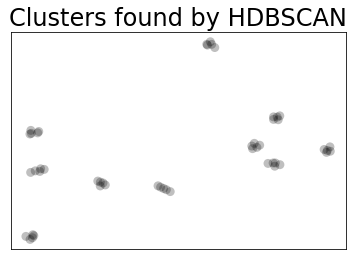

In [13]:
%time hv.plot_clusters(UMAP().fit_transform(A), hdbscan.HDBSCAN, (), {'min_cluster_size':15})

In [ ]:
6%4

In [ ]:
%%cython -a

tab_b = bytes.maketrans(b"ACGT", b"TGCA")

cdef unsigned char *bRevComp(bytes seq):
    return seq.translate(tab_b)[::-1]

cdef char char_transform(char charels):
    if charels == 65: return 84
    elif charels == 67: return 71
    elif charels == 71: return 67
    elif charels == 84: return 65
    return 78

cdef unsigned char *OK(unsigned char *kmer, int val):
    cdef int i = 0
    while i < val:
        if kmer[i] <char_transform(kmer[val - i-1]):
            return kmer
        elif kmer[i] > char_transform(kmer[val - i-1]):
            return bRevComp(kmer)
        i +=1
    return kmer


def sklearn_ngram_yield_fast(unsigned char *text, int n):
    cdef int text_len = len(text) 
    cdef int i = 0 
    for i in range(text_len - n):
        yield <bytes>(OK(text[i: i + n], n))
        
def sklearn_ngram_yield_fast_old(text, int n):
    cdef int text_len = len(text)
    cdef int i = 0 
    for i in range(text_len - n):
        yield OK(text[i: i + n], n)
        

def yieldkmers( filename, klen = 20):
    with open(filename, 'rb') as f:
        while 1:
            if not f.readline(): break
            for i in sklearn_ngram_yield_fast(f.readline(), klen): yield i
            f.readline()
            f.readline()  
            
def listkmers(filename, klen = 20):
    return list(yieldkmers(filename, klen))



In [ ]:
%timeit list(sklearn_ngram_yield_fast(b'ACTT', 3))
%timeit list(sklearn_ngram_yield_fast_old(b'ACTTACGCTAGCTACGCTA', 3))
#%timeit sklearn_ngram_fast(b'ACTTACGCTAGCTACGCTA', 3))

In [ ]:
%timeit list(sklearn_ngram_yield_fast(b'CCTCCACCCACACCGATGCTGCATCGATACGTACGTACGACTGACTACAA\n', 15))

In [ ]:
%timeit list(ngrams(b'ACTTACGCTAGCTACGCTA', 3))

In [ ]:
list(sklearn_ngram_yield_fast(b'ACTTACGCTAGCTACGCTA', 3))

In [ ]:
list(yieldkmers('data/000genome.txt',20))

In [ ]:
A[0,1] = 1

In [ ]:
A[0,0]

In [ ]:
A = da.zeros((1, 1000000), chunks=(1, 1000), dtype = 'int')

In [ ]:
data = [1,2,3,4,5]*100
row = [10, 100000, 1 ,0, 111]*100
col = [0,0,0,0,0]*100

In [ ]:
%timeit A = coo_matrix((data, (row, col)), shape=(10000000, 1), dtype = 'int')

In [ ]:
import dask.array as da
import sys

In [ ]:
 coo_matrix((data, (row, col)), shape=(4, 4), dtype = 'int')

In [ ]:
A = coo_matrix((data, (row, col)), shape=(4**32, 1), dtype = 'int')

In [ ]:
class

In [ ]:
import numpy as np

In [ ]:
%%cython -a

###### hash vectorizer #############################################
cimport numpy as cnp
from libc.stdlib cimport malloc, free
from libc.stdio cimport fopen, fclose, FILE, EOF, fgetc, feof
from scipy.sparse import coo_matrix
from cython.parallel import prange
import numpy as np

cdef unsigned char char_transform(unsigned char chars):
    if chars == 65: return 84
    elif chars == 67: return 71
    elif chars == 71: return 67
    elif chars == 84: return 65
    return 78

cdef unsigned char char2int(char chars):
    if chars == 65: return 0
    elif chars == 67: return 1
    elif chars == 71: return 2
    elif chars == 84: return 3
    return -1

cdef char check_sort2(unsigned char * fw, unsigned char * rv, int klen):
    cdef int i
    for i in range(klen):
        if fw[i] < rv[i]: return 1
        elif fw[i] > rv[ i]: return 0
    return 1

cdef int RevHash(unsigned char *kmer):
    cdef unsigned char c
    cdef int rev = 0
    cdef int i
    for i in range(len(kmer)):
        rev = rev*4 + char2int(kmer[i])
    return rev

cdef long longRevHash(unsigned char *kmer):
    cdef unsigned char c
    cdef long rev = 0
    cdef int i
    for i in range(len(kmer)):
        rev = rev*4 + char2int(kmer[i])
    return rev

cdef list cycols(str filename, int klen):
    """Efficiently read in a file"""
    cdef FILE *fp = NULL # create a file pointer
    fp = fopen(filename.encode(encoding='utf-8'), "rb")
    if fp == NULL:
        raise FileNotFoundError(2, "No such file or directory: '%s'" % filename)
    # file parsing variables
    cdef char c 
    cdef int i
    cdef int is_line = 1 
    cdef int window_pos = 0
    cdef bytes pywindow 
    cdef unsigned char *cwindow = <unsigned char *> malloc((klen+1)*sizeof(char))
    cdef unsigned char *invcwindow = <unsigned char *> malloc((klen+1)*sizeof(char))
    cdef list col = []

    #cdef int stopearly = 0
    # bypass the gil
    #with nogil:
    while 1 :
        c = fgetc(fp)
        if feof(fp): break
        if c == 78: window_pos = 0
        elif c == 10: 
            is_line += 1
            if is_line > 4: is_line= 1
            window_pos = 0
        elif is_line == 2: 
            cwindow[window_pos] = c
            invcwindow[klen - window_pos-1] = char_transform(c)
            window_pos += 1
            if window_pos == klen: 
                if check_sort2(cwindow, invcwindow, klen ) == 1: 
                    col.append(longRevHash(cwindow))
                else: col.append(longRevHash(invcwindow))
                for i in range(klen-1): cwindow[i] = cwindow[i+1]
                for i in range(klen-2,-1,-1): invcwindow[i+1] = invcwindow[i]
                window_pos -= 1
    # close the file
    free(cwindow)
    free(invcwindow)
    fclose(fp)
    return col

def cyhashvectorizer(list filenames = [], int klen = 20, memorysafe = True):
    cdef long long size = 4**klen #cdef long long 
    cdef int corpus_size = len(filenames)
    ret = coo_matrix(([], ([],[])),shape=(corpus_size, size), dtype = 'int')
    for  num,name  in enumerate(filenames):
        col = cycols(name, klen)
        length = len(col)
        ret += coo_matrix((np.ones(length, dtype = int), (np.full(length, num, dtype=int), col)), shape=(corpus_size, size), dtype = 'int')
        if memorysafe: ret.sum_duplicates()
    return ret.tocsr()


In [ ]:
from glob import glob
filenames = sorted(glob('data/*genome.txt'))
import hashvec as hv

In [ ]:
filenames[:10]

In [ ]:
%time X  = cyhashvectorizer(filenames[:100], 15, memorysafe= False )

In [ ]:
%time hv.plot_clusters(UMAP().fit_transform(X), hdbscan.HDBSCAN, (), {'min_cluster_size':15})


In [ ]:
%%time 
a = [1 for x in range]